# 12. 포아송-음이항회귀

In [2]:
library(bayesrules)
library(rstanarm)
library(bayesplot)
library(tidyverse)
library(tidybayes)
library(broom.mixed)

In [3]:
data(equality_index)
equality <- equality_index

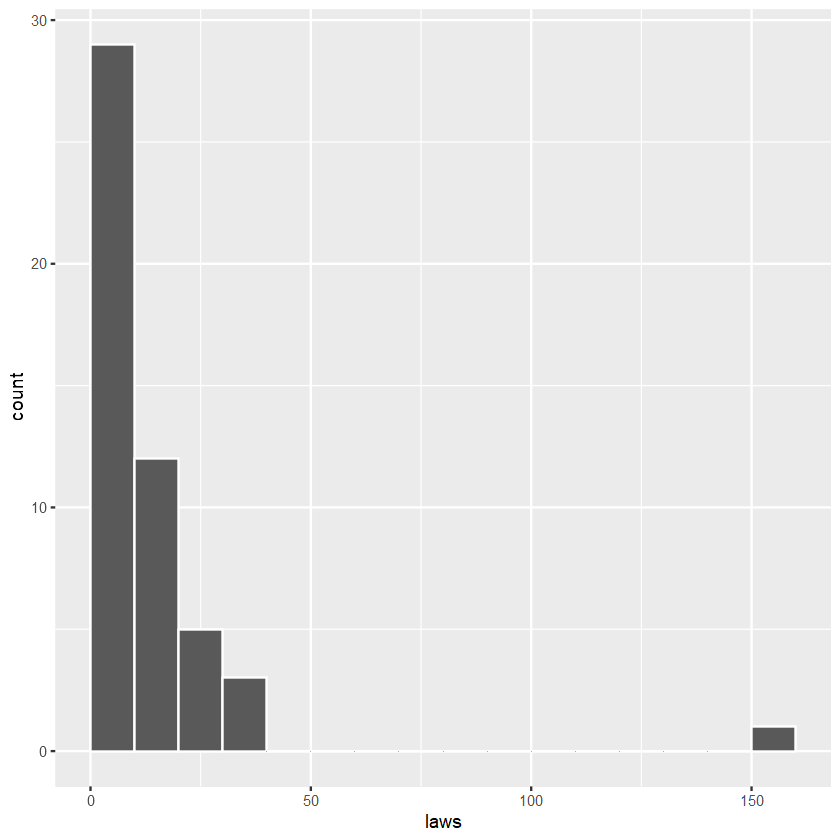

In [5]:
ggplot(equality, aes(x = laws)) + 
  geom_histogram(color = "white", breaks = seq(0, 160, by = 10))

In [7]:
equality %>% 
  filter(laws == max(laws))

state,region,gop_2016,laws,historical,percent_urban
<fct>,<fct>,<dbl>,<dbl>,<fct>,<dbl>
california,west,31.62,155,dem,95


In [8]:
equality <- equality %>% 
  filter(state != "california")

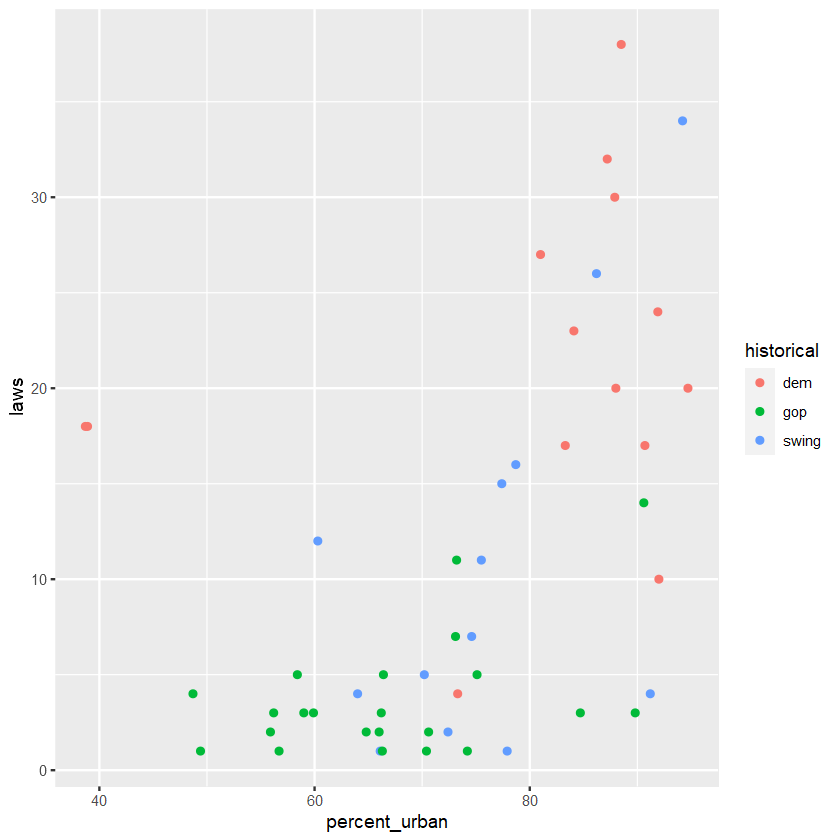

In [9]:
ggplot(equality, aes(y = laws, x = percent_urban, color = historical)) + 
  geom_point()

<br>

### 정규회귀에 대한 MCMC 시뮬레이션

In [ ]:
equality_normal_sim <- stan_glm(laws ~ percent_urban + historical, 
                                data = equality, 
                                family = gaussian,
                                prior_intercept = normal(7, 1.5),
                                prior = normal(0, 2.5, autoscale = TRUE),
                                prior_aux = exponential(1, autoscale = TRUE),
                                chains = 4, iter = 5000*2, seed = 84735)

In [12]:
prior_summary(equality_normal_sim)

Priors for model 'equality_normal_sim' 
------
Intercept (after predictors centered)
 ~ normal(location = 7, scale = 1.5)

Coefficients
  Specified prior:
    ~ normal(location = [0,0,0], scale = [2.5,2.5,2.5])
  Adjusted prior:
    ~ normal(location = [0,0,0], scale = [ 1.79,51.23,57.71])

Auxiliary (sigma)
  Specified prior:
    ~ exponential(rate = 1)
  Adjusted prior:
    ~ exponential(rate = 0.097)
------
See help('prior_summary.stanreg') for more details

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


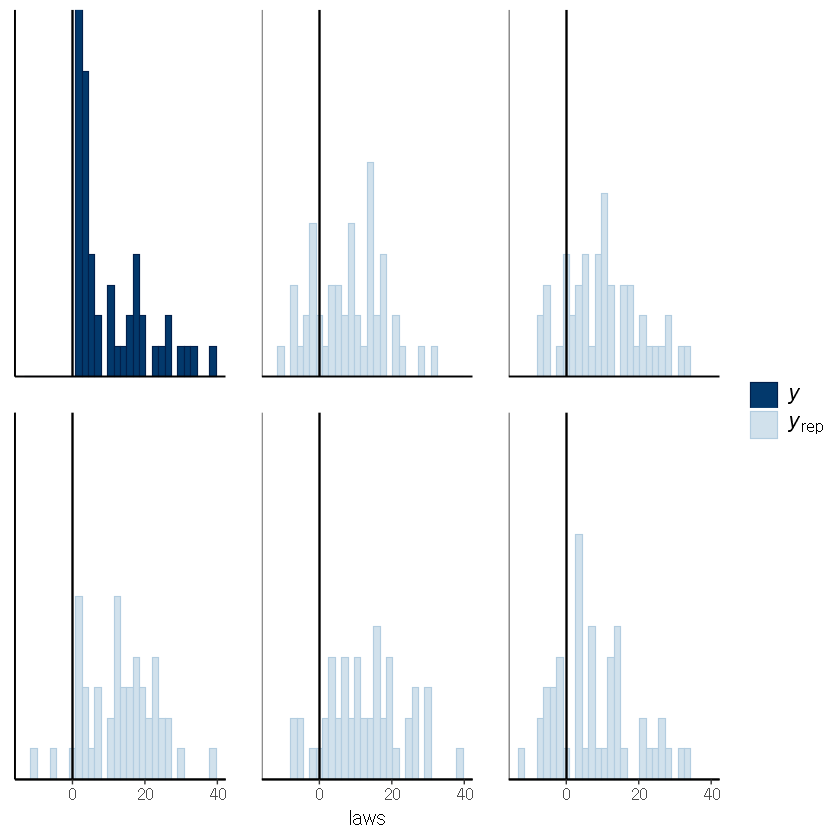

In [11]:
pp_check(equality_normal_sim, plotfun = "hist", nreps = 5) + 
  geom_vline(xintercept = 0) + 
  xlab("laws")

<br>

## 12.01. 포아송 회귀 
- **포아송 분포는 고정된 공간 또는 시간 간격(여기서는 상태)에서 발생하고 이론적으로 상한이 없는 사건의 개별 개수를 모델링하는 데 적합**

    - 분포가 오른쪽으로 치우쳐 정규분포 모형으로 근사화할 수 없는 경우에 특히 유용

<br>

### 포아송 회귀 가정

- 각 관측값 $Y_i$는 서로 독립이라고 가정
$$Y_i | \lambda_i \stackrel{ind}{\sim} Pois\left(\lambda_i \right)  .$$

$$E(Y_i | \lambda_i) = \lambda_i  .$$




<br>

- $\lambda_i$는 설명변수의 선형결합이라고 가정

$$\lambda_i = \beta_0 + \beta_1 X_{i1} + \beta_2 X_{i2} + \beta_3 X_{i3}$$

- 하지만, $\lambda_i$는 항상 양수를 가져야 하기에, 로그연결함수를 사용하며,

    포아송 회귀는 아래와 같은 가정을 사용

$$Y_i | \beta_0,\beta_1, \beta_2, \beta_3 \stackrel{ind}{\sim} Pois\left(\lambda_i \right) 
\;\;\; \text{ with } \;\;\; 
\log\left( \lambda_i \right) = \beta_0 + \beta_1 X_{i1} + \beta_2 X_{i2} + \beta_3 X_{i3}  .$$

$$Y_i | \beta_0,\beta_1, \beta_2, \beta_3 \stackrel{ind}{\sim} Pois\left(\lambda_i\right) \;\; \text{ with } \;\; \lambda_i = e^{\beta_0 + \beta_1 X_{i1} + \beta_2 X_{i2} + \beta_3 X_{i3}}  .$$

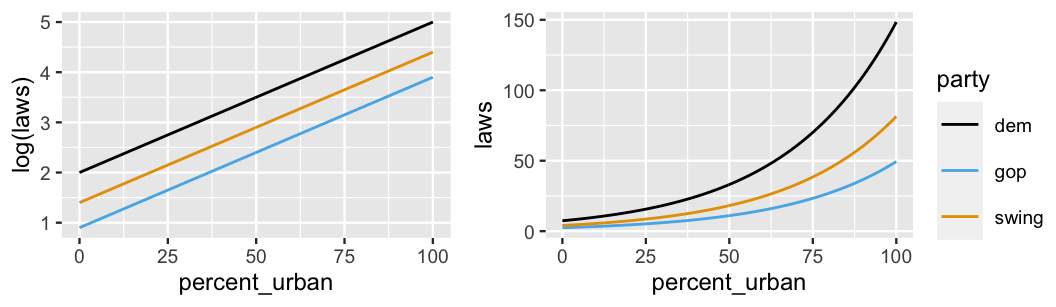

<br>

### 포아송 회귀계수 해석
> $Y|\beta_0,\beta_1,\ldots,\beta_p \sim \text{Pois}(\lambda)$가 가정된 포아송 회귀모형
>
> $$\begin{equation}
\begin{split}
\log(\lambda) & = \beta_0 + \beta_1 X_1 + \cdots \beta_p X_p \\
\lambda & = e^{\beta_0 + \beta_1 X_1 + \cdots \beta_p X_p}. \\
\end{split}
\end{equation}$$에서

> $\beta_0$ :
> 
>> $X_1, X_2, \ldots, X_p$가 모두 0일 떄, $\beta_0$는  $Y$의 로그평균이고, $e^{\beta_0}$는 $Y$의 평균

> $\beta_1$와 $\beta_2, \ldots, \beta_p$:
> 
>> $\lambda_x$가 $X_1 = x$일 때 $Y$의 평균이고, $\lambda_{x+1}$가 $X_1 = x+1$일 때 $Y$ 평균이라면, 
>>
>> $X_2, \ldots, X_p$변수가 통제되었고 $X_1$이 한 단위 증가하였을 때의, 로그$\lambda$의 변화량 (=$Y$의 로그평균 변화량)
> $$\beta_1 = \log(\lambda_{x+1}) - \log(\lambda_x)
\;\;\;\; \text{ and } \;\;\;\;
e^{\beta_1} = \frac{\lambda_{x+1}}{\lambda_x}  .$$

<br>

#### 포아송 회귀모형이 아래와 같을 때,
$$\begin{equation}
\begin{split}
\log(\lambda) & = 2 + 0.03X_{i1} - 1.1X_{i2} - 0.6X_{i3} \\
\lambda       & = e^{2 + 0.03X_{i1} - 1.1X_{i2} - 0.6X_{i3}}. \\
\end{split}
\end{equation}$$

- $\beta_0=2$는 $X_{i1} = X_{i2} = X_{i3} = 0$일 때의 $\lambda$의 로그추정량, $e^{2}$는 $\lambda$의 추정량

$$e^{\beta_0} = e^2 = 7.389 .$$

- $e^{\beta_1} = e^{0.03} = 1.03  .$은 $X_{i1}$이 한 단위 증가하였을 때, $\lambda$ 추정량의 변화율 
    
    $X_{i1}$증가 이후 1.03배 증가
    
<br>

- $e^{\beta_2} = e^{-1.1} = 0.333  .$은 $X_{i2}$이 한 단위 증가하였을 때, $\lambda$ 추정량의 변화율 
    
    $X_{i2}$증가 이후의 평균이, 증가하기 이전의 1/3배
    

<br>

### 사전분포 설정

- 각 회귀계수들에 대한 사전분포는, 정규회귀와 마찬가지로 정규사전분포를 가정
* $\beta_0$에 대한 사전분포는, $log(\lambda)$에 대한 사전정보와 연결

    - 예) $\lambda$가 평균적으로 7이라고 가정 $\rightarrow$ $\beta_0$에 대한 사전분포는
    
        $$\log(\lambda) = \log(7) \approx 1.95  .$$

<br>


<br>

### MCMC 시뮬레이션 (사전분포 autoscale)

In [ ]:
equality_model_prior <- stan_glm(laws ~ percent_urban + historical, 
                                 data = equality, 
                                 family = poisson,
                                 prior_intercept = normal(2, 0.5),
                                 prior = normal(0, 2.5, autoscale = TRUE), 
                                 chains = 4, iter = 5000*2, seed = 84735, 
                                 prior_PD = TRUE)

In [20]:
prior_summary(equality_model_prior)

Priors for model 'equality_model_prior' 
------
Intercept (after predictors centered)
 ~ normal(location = 2, scale = 0.5)

Coefficients
  Specified prior:
    ~ normal(location = [0,0,0], scale = [2.5,2.5,2.5])
  Adjusted prior:
    ~ normal(location = [0,0,0], scale = [0.17,4.97,5.60])
------
See help('prior_summary.stanreg') for more details


$$\begin{equation}
\begin{array}{lcrl} 
\text{data:} & \hspace{.025in} & Y_i|\beta_0,\beta_1,\beta_2,\beta_3 & \stackrel{ind}{\sim} Pois\left(\lambda_i \right) \;\; \text{ with } \;\;
\log\left( \lambda_i \right) = \beta_0 + \beta_1 X_{i1} + \beta_2 X_{i2}+ \beta_3 X_{i3} \\
\text{priors:} & & \beta_{0c} & \sim N\left(2, 0.5^2 \right) \\
&& \beta_1 & \sim N(0, 0.17^2) \\
&& \beta_2 & \sim N(0, 4.97^2) \\
&& \beta_3 & \sim N(0, 5.60^2) \\
\end{array}
\end{equation}$$

Warning message:
"`fitted_draws` and `add_fitted_draws` are deprecated as their names were confusing.
- Use [add_]epred_draws() to get the expectation of the posterior predictive.
- Use [add_]linpred_draws() to get the distribution of the linear predictor.
- For example, you used [add_]fitted_draws(..., scale = "response"), which
  means you most likely want [add_]epred_draws(...).
NOTE: When updating to the new functions, note that the `model` parameter is now
  named `object` and the `n` parameter is now named `ndraws`."
Warning message:
"Removed 1364 rows containing missing values (`geom_line()`)."


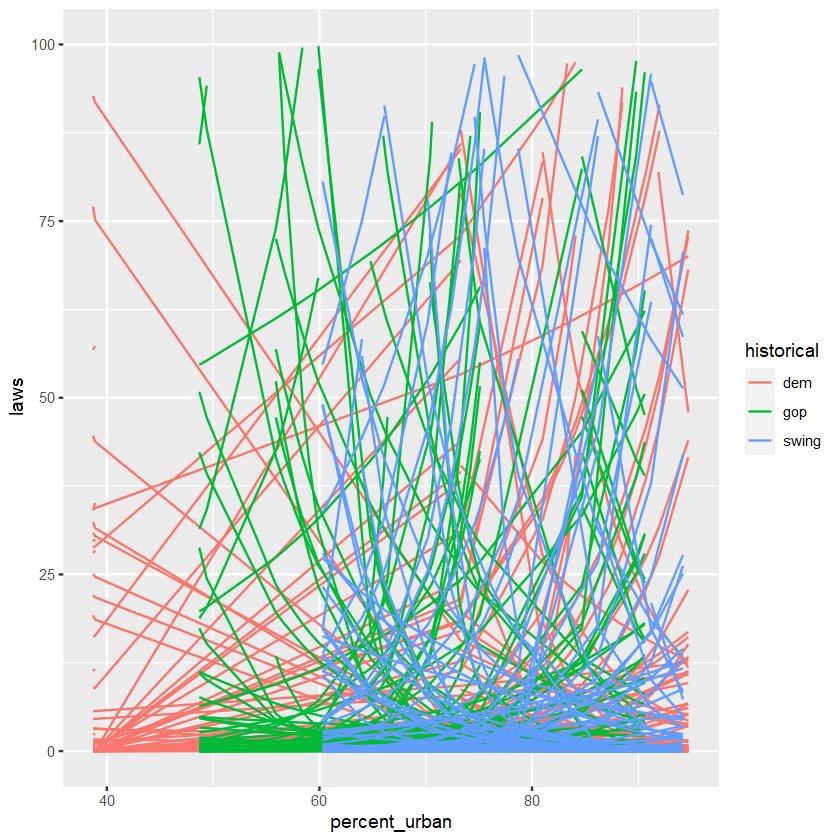

In [21]:
equality %>% 
  add_fitted_draws(equality_model_prior, n = 100) %>%
  ggplot(aes(x = percent_urban, y = laws, color = historical)) +
    geom_line(aes(y = .value, group = paste(historical, .draw))) + 
    ylim(0, 100)

<br>

## 12.02. 사후분포 시뮬레이션

#### autoscale된 사전분포로 다시 시뮬레이션

In [ ]:
equality_model <- update(equality_model_prior, prior_PD = FALSE)

<br>

### 시뮬레이션 결과 확인

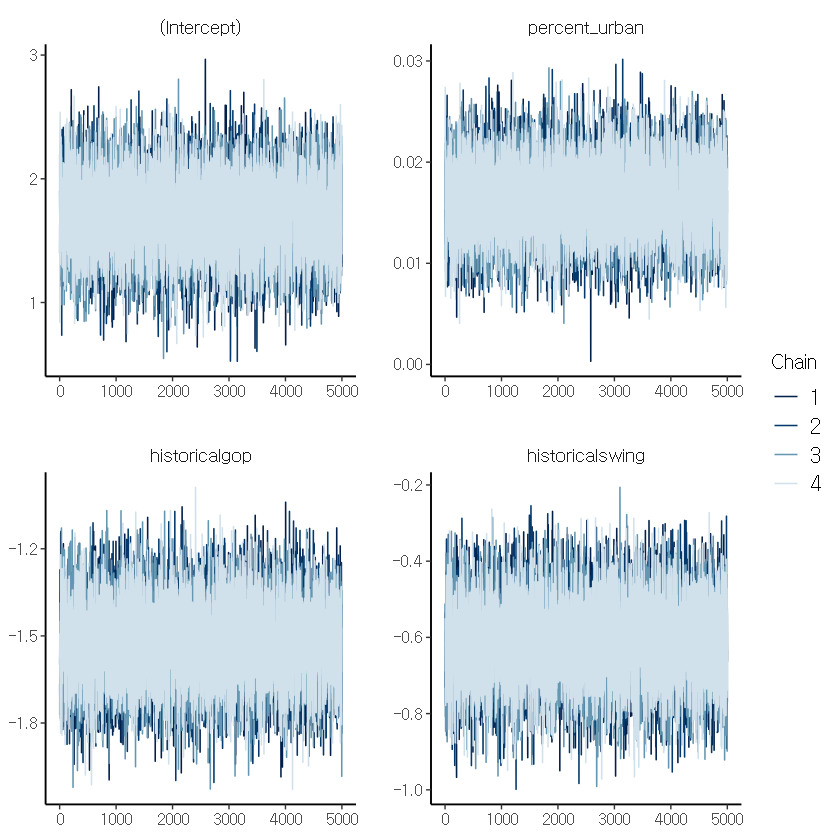

Warning message:
"The `facets` argument of `facet_grid()` is deprecated as of ggplot2 2.2.0.
ℹ Please use the `rows` argument instead.
ℹ The deprecated feature was likely used in the bayesplot package.
  Please report the issue at <https://github.com/stan-dev/bayesplot/issues/>."


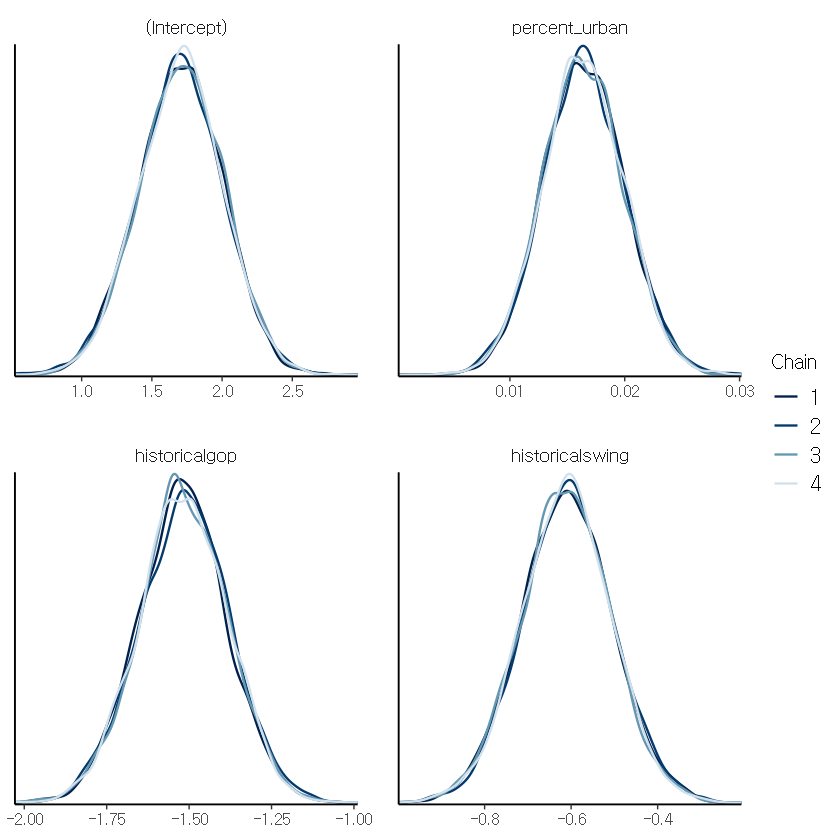

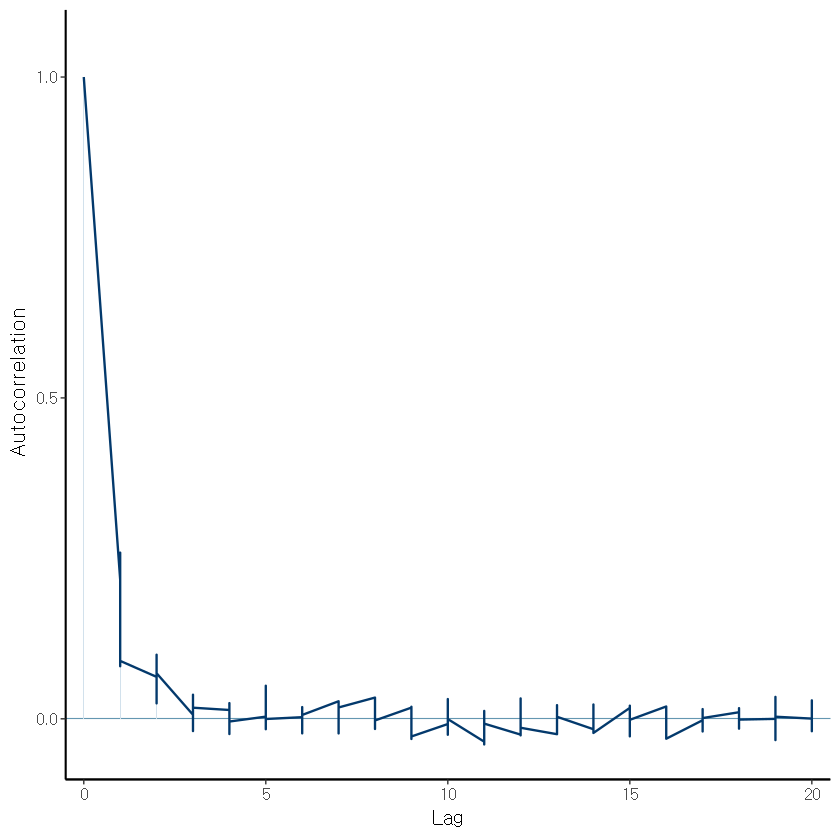

In [23]:
mcmc_trace(equality_model)
mcmc_dens_overlay(equality_model)
mcmc_acf(equality_model)

<br>

### 사후예측분포 검사
- 시뮬레이션에 의한 사후예측분포가, 데이터의 중심성과 특성을 어느정도 잘 나타내는 것을 확인

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


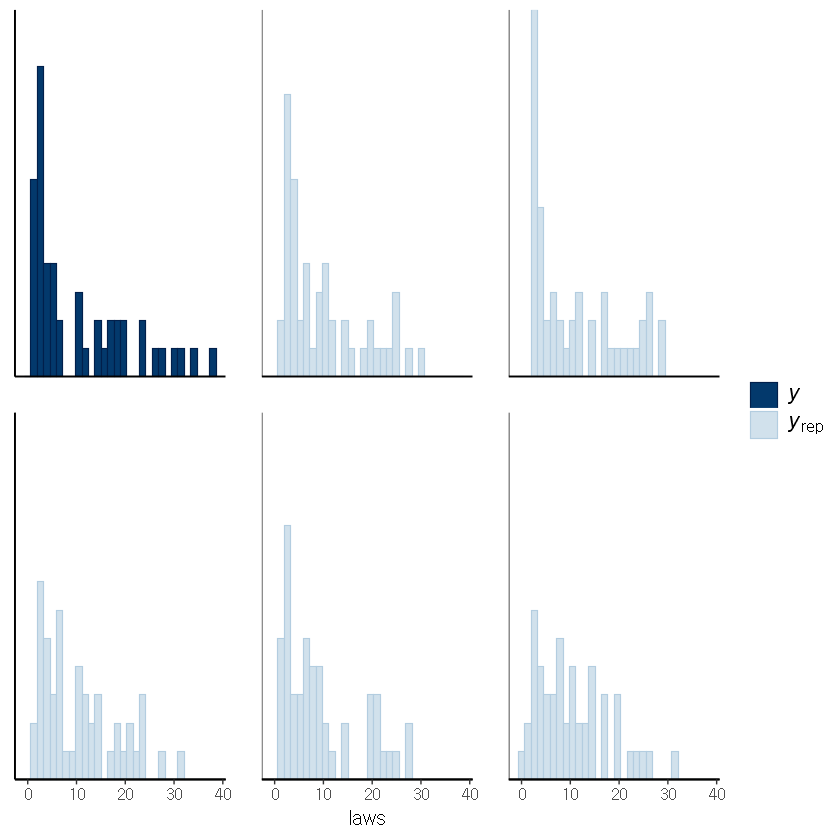

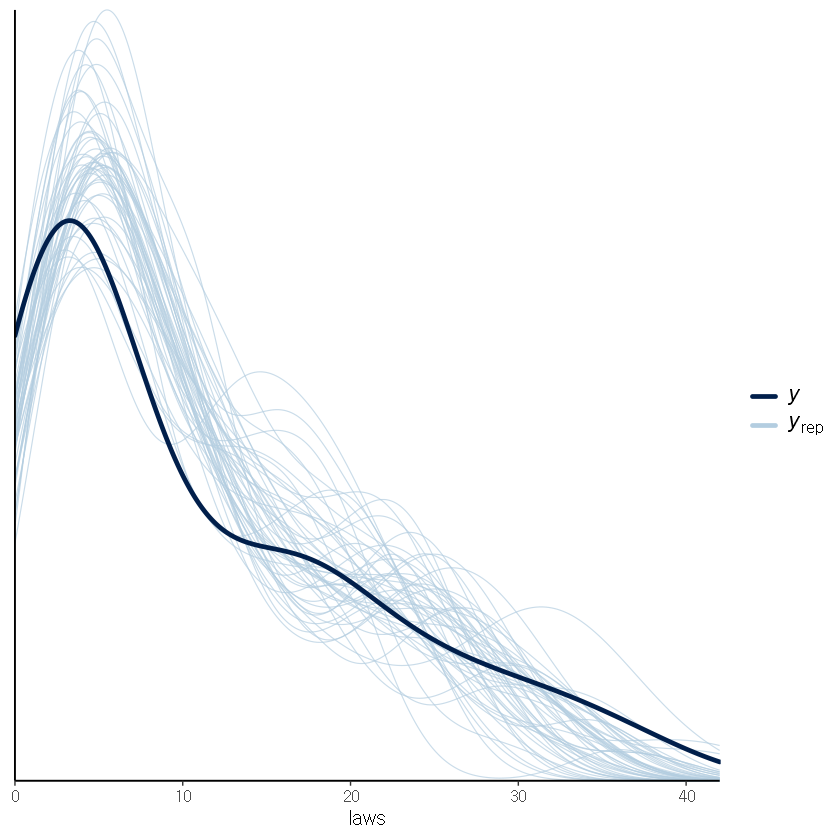

In [24]:
set.seed(1)
pp_check(equality_model, plotfun = "hist", nreps = 5) + 
  xlab("laws")

pp_check(equality_model) + 
  xlab("laws")

<br>

## 12.03 사후분포 해석

Warning message:
"`fitted_draws` and `add_fitted_draws` are deprecated as their names were confusing.
- Use [add_]epred_draws() to get the expectation of the posterior predictive.
- Use [add_]linpred_draws() to get the distribution of the linear predictor.
- For example, you used [add_]fitted_draws(..., scale = "response"), which
  means you most likely want [add_]epred_draws(...).
NOTE: When updating to the new functions, note that the `model` parameter is now
  named `object` and the `n` parameter is now named `ndraws`."


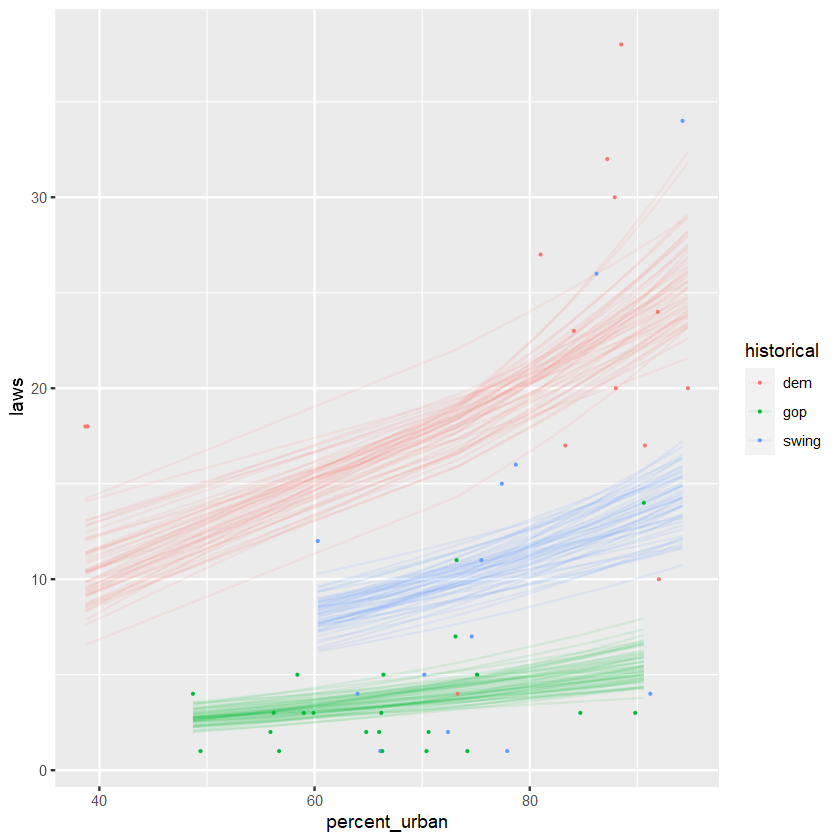

In [25]:
equality %>%
  add_fitted_draws(equality_model, n = 50) %>%
  ggplot(aes(x = percent_urban, y = laws, color = historical)) +
    geom_line(aes(y = .value, group = paste(historical, .draw)), 
              alpha = .1) +
    geom_point(data = equality, size = 0.1)

<br>

### 매개변수별 사후분포 통계량

$$\begin{equation}
\begin{split}
\log(\lambda_i) 
& = 1.71 + 0.0164 X_{i1} - 1.52 X_{i2} - 0.61 X_{i3} \\
\lambda_i 
& = e^{1.71 + 0.0164 X_{i1} - 1.52 X_{i2} - 0.61 X_{i3}}. \\
\end{split}
\end{equation}$$

In [26]:
tidy(equality_model, conf.int = TRUE, conf.level = 0.80)

term,estimate,std.error,conf.low,conf.high
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),1.7094860,0.302511685,1.3088237,2.09070916
percent_urban,0.0163877,0.003534599,0.0119494,0.02101983
historicalgop,-1.5170536,0.134075263,-1.6913264,-1.34359986
historicalswing,-0.6098389,0.103185056,-0.7447665,-0.47694044


<br>

## 12.04. 사후예측분포

### $percent\_urban = 73.3$이고, $historical=dem$인 관측값

In [27]:
equality %>% 
  filter(state == "minnesota")

state,region,gop_2016,laws,historical,percent_urban
<fct>,<fct>,<dbl>,<dbl>,<fct>,<dbl>
minnesota,midwest,44.92,4,dem,73.3


<br>

### 각 마르코프 체인 값 (매개변수 조합)에 관측값을 대입 $\rightarrow$ 관측값에 대한 사후예측분포 생성

마르코프 체인 값 $\left(\beta_0^{(i)}, \beta_1^{(i)}, \beta_2^{(i)}, \beta_3^{(i)}\right)$에 대해서

$\log(\lambda^{(i)}) = \beta_0^{(i)} +  \beta_1^{(i)}\cdot 73.3 + \beta_2^{(i)}\cdot0 + \beta_3^{(i)} \cdot 0$을 통하여

#### $\log(\lambda^{(i)})$에 대한 사후예측분포

In [30]:
set.seed(84735)

mn_prediction <- posterior_predict(
  equality_model, newdata = data.frame(percent_urban = 73.3, 
                                       historical = "dem"))

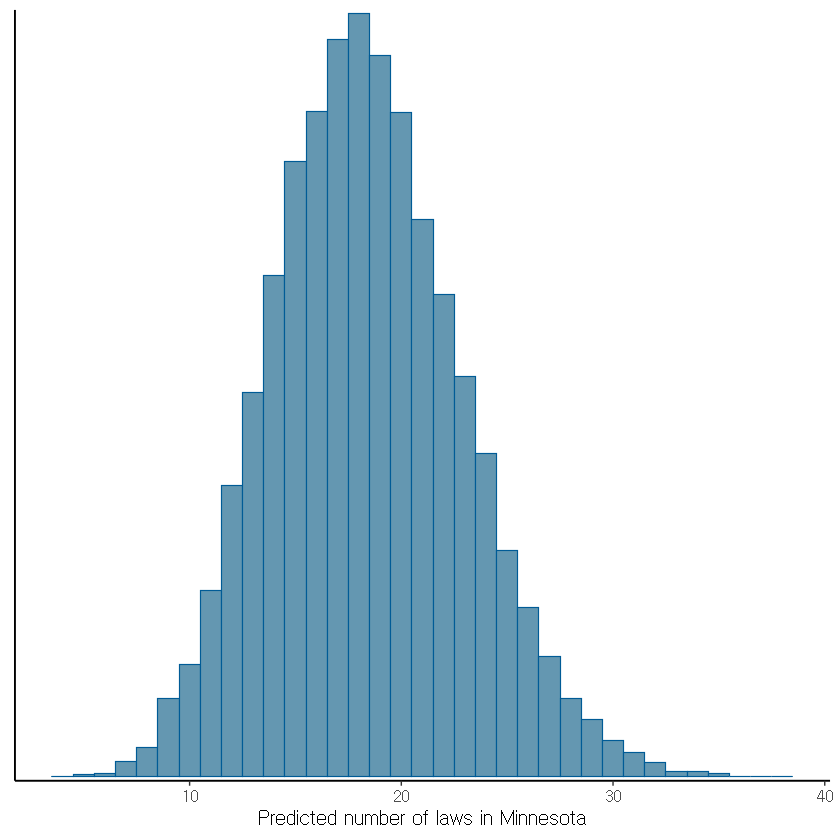

In [33]:
mcmc_hist(mn_prediction, binwidth = 1) + 
  xlab("Predicted number of laws in Minnesota")

<br>

#### $\lambda^{(i)} = e^{\beta_0^{(i)} +  \beta_1^{(i)}\cdot 73.3 + \beta_2^{(i)}\cdot0 + \beta_3^{(i)} \cdot 0}$에 대한 사후예측분포

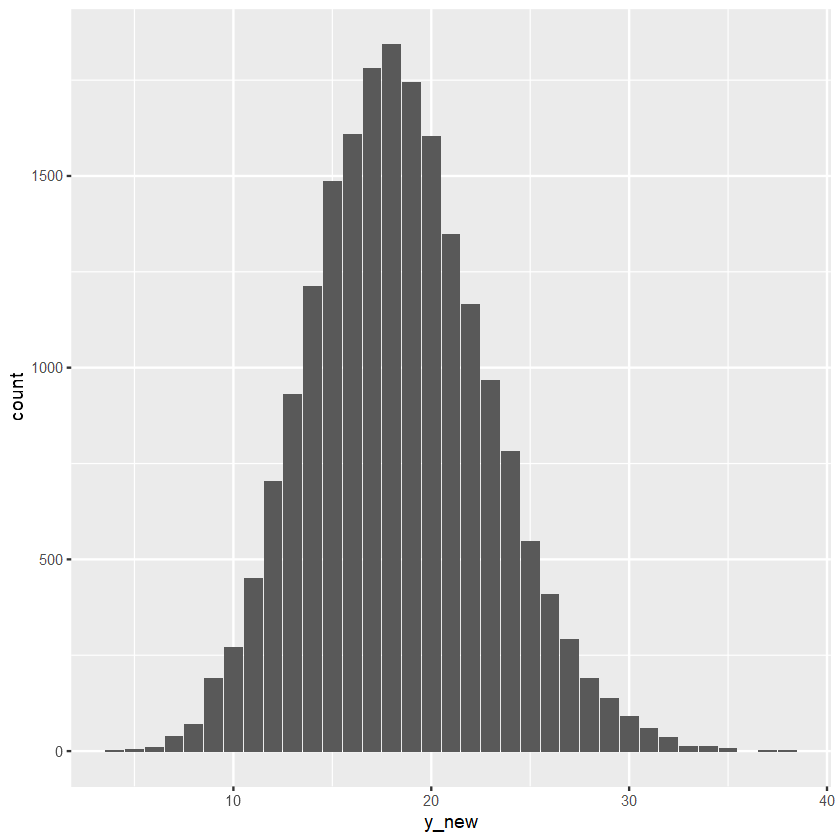

In [32]:
set.seed(84735)

as.data.frame(equality_model) %>% 
  mutate(log_lambda = `(Intercept)` + percent_urban*73.3 + 
           historicalgop*0 + historicalswing*0,
         lambda = exp(log_lambda),
         y_new = rpois(20000, lambda = lambda)) %>% 
  ggplot(aes(x = y_new)) + 
    stat_count()

<br>

## 12.05. 모형평가

In [34]:
set.seed(84735)
poisson_predictions <- posterior_predict(equality_model, newdata = equality)

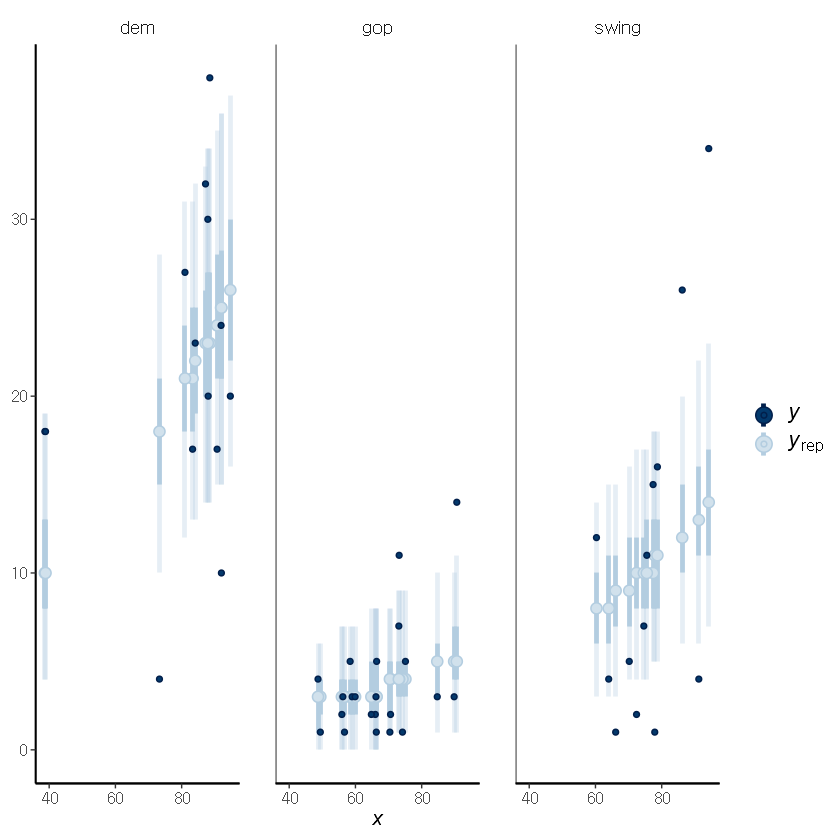

In [35]:
ppc_intervals_grouped(equality$laws, yrep = poisson_predictions, 
                      x = equality$percent_urban, 
                      group = equality$historical,
                      prob = 0.5, prob_outer = 0.95,
                      facet_args = list(scales = "fixed"))

In [36]:
prediction_summary(model = equality_model, data = equality)

mae,mae_scaled,within_50,within_95
<dbl>,<dbl>,<dbl>,<dbl>
3.3824,1.301441,0.3265306,0.7755102


<br>

#### 교차검증

In [37]:
set.seed(84735)
poisson_cv <- prediction_summary_cv(model = equality_model, 
                                    data = equality, k = 10)
poisson_cv$cv

mae,mae_scaled,within_50,within_95
<dbl>,<dbl>,<dbl>,<dbl>
3.78785,1.264107,0.3,0.725


<br>

## 12.06. 과분산 변수에 대한 음이항 회귀

### 과분산
> **$Y$에 대하여 가정된 분포의 분산보다, $Y$의 분산이 더 크다면, $Y$는 과분산 된 것**

<br>


<br>

#### `books`변수는 과분산된 변수

In [38]:
data(pulse_of_the_nation)

pulse <- pulse_of_the_nation %>% 
  filter(books < 100)

In [43]:
pulse %>% 
  summarize(mean = mean(books), var = var(books))

mean,var
<dbl>,<dbl>
10.8654,197.6345


In [44]:
pulse %>% 
  group_by(cut(age,3), wise_unwise) %>% 
  summarize(mean = mean(books), var = var(books))

`summarise()` has grouped output by 'cut(age, 3)'. You can override using the `.groups` argument.


"cut(age, 3)",wise_unwise,mean,var
<fct>,<fct>,<dbl>,<dbl>
"(17.9,45]",Happy but Unwise,9.228261,137.57603
"(17.9,45]",Wise but Unhappy,12.603093,195.17325
"(45,72]",Happy but Unwise,9.357639,182.84377
"(45,72]",Wise but Unhappy,12.502242,270.25112
"(72,99.1]",Happy but Unwise,12.580645,236.31828
"(72,99.1]",Wise but Unhappy,10.225806,97.04731


<br>

#### 포아송 분포가 가정된 포아송 회귀의 사후분포는, 관측값의 중심성과 특성을 잘 반영하지 못함
#### $\rightarrow$ 따라서, 분산과 평균이 동일한 포아송 분포를 활용한 회귀를 적용하는 것은, 적절하지 않음

In [ ]:
books_poisson_sim <- stan_glm(
  books ~ age + wise_unwise, 
  data = pulse, family = poisson,
  prior_intercept = normal(0, 2.5, autoscale = TRUE),
  prior = normal(0, 2.5, autoscale = TRUE), 
  prior_aux = exponential(1, autoscale = TRUE),
  chains = 4, iter = 5000*2, seed = 84735)

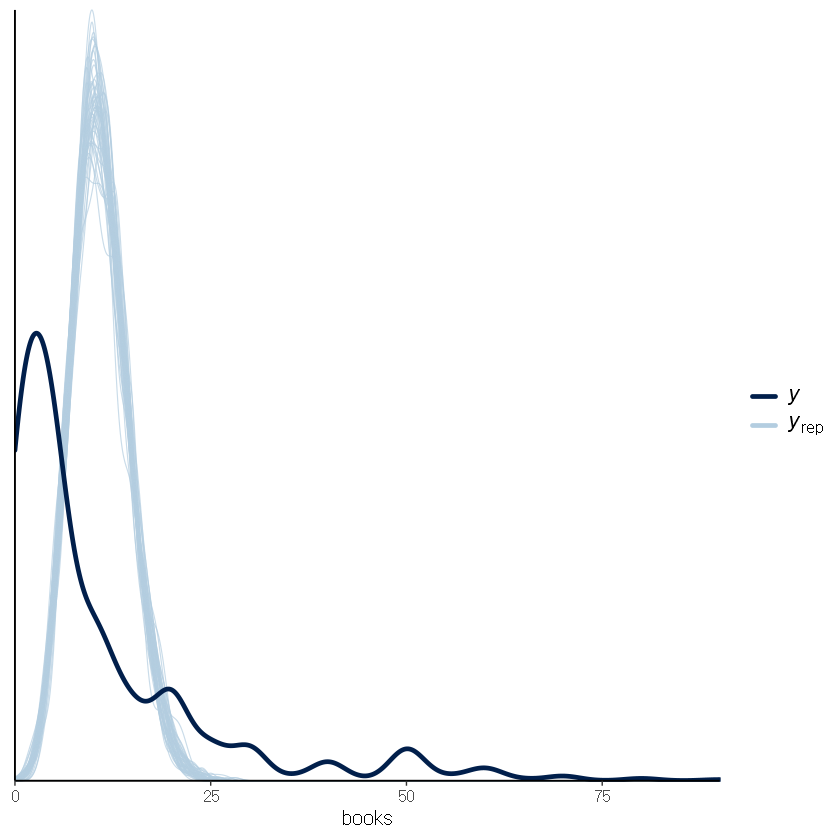

In [41]:
pp_check(books_poisson_sim) + 
  xlab("books")

<br>

### 음이항분포
> $Y \in \{0,1,2,\ldots\}$인 변수에 대하여, 
>
> 평균 매개변수 $\mu$와 산포 매개변수 $r$를 가진 음이항 분포를 가정할 수 있음

> 음이항 분포의 확률밀도함수
> $$\begin{equation}
f(y|\mu,r) =  \left(\!\begin{array}{c} y + r - 1 \\ r \end{array}\!\right)  \left(\frac{r}{\mu + r} \right)^r \left(\frac{\mu}{\mu + r} \right)^y\;\; \text{ for } y \in \{0,1,2,\ldots\}
\end{equation}$$

> 평균과 분산
> $$E(Y|\mu,r) = \mu \;\; \text{ and } \;\; \text{Var}(Y|\mu,r) = \mu + \frac{\mu^2}{r}.$$

> **산포 매개변수 $r$이 클수록 $\text{Var}(Y) \approx E(Y)$의 경향이 높아지며, 포아송 분포와 유사해짐**
>
> **$r$이 작아질수록 $\text{Var}(Y) > E(Y)$의 경향이 높아지며, 같은 평균을 가진 포아송 분포에 비해서 분포의 산포도가 높아짐 (과분산됨)**

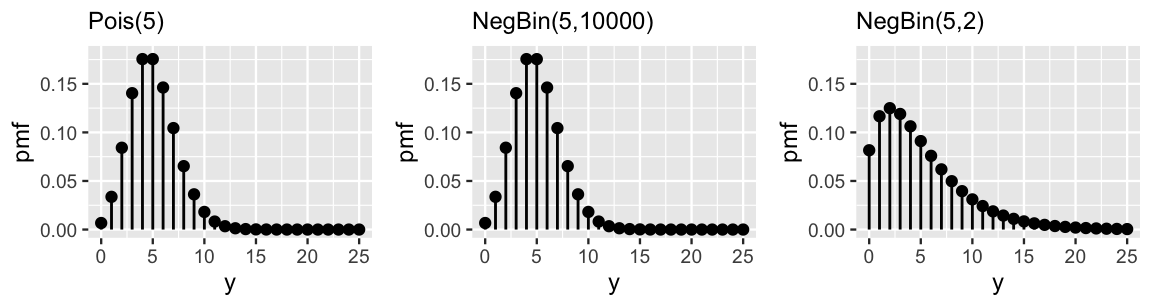

<br>

### 음이항 회귀 시뮬레이션 (사전분포 autoscale)

In [ ]:
books_negbin_sim <- stan_glm(
  books ~ age + wise_unwise, 
  data = pulse, family = neg_binomial_2,
  prior_intercept = normal(0, 2.5, autoscale = TRUE),
  prior = normal(0, 2.5, autoscale = TRUE), 
  prior_aux = exponential(1, autoscale = TRUE),
  chains = 4, iter = 5000*2, seed = 84735)

In [46]:
prior_summary(books_negbin_sim)

Priors for model 'books_negbin_sim' 
------
Intercept (after predictors centered)
 ~ normal(location = 0, scale = 2.5)

Coefficients
  Specified prior:
    ~ normal(location = [0,0], scale = [2.5,2.5])
  Adjusted prior:
    ~ normal(location = [0,0], scale = [0.15,5.01])

Auxiliary (reciprocal_dispersion)
 ~ exponential(rate = 1)
------
See help('prior_summary.stanreg') for more details

$$\begin{equation}
\begin{array}{lcrl} 
\text{data:} & \hspace{.025in} & Y_i|\beta_0,\beta_1,\beta_2,r & \stackrel{ind}{\sim} \text{NegBin}\left(\mu_i, r \right) \;\; \text{ with } \;\; \log\left( \mu_i \right) = \beta_0 + \beta_1 X_{i1} + \beta_2 X_{i2} \\
\text{priors:} & & \beta_{0c}  & \sim N\left(0, 2.5^2\right) \\
 & & \beta_1  & \sim N\left(0, 0.15^2\right) \\
 & & \beta_2  & \sim N\left(0, 5.01^2\right) \\
& & r & \sim \text{Exp}(1)\\
\end{array}
\end{equation}$$

<br>

#### 음이항 분포가 가정된, 음이항 회귀의 사후분포는 데이터의 특성을 잘 반영함을 확인

Warning message:
"Removed 193 rows containing non-finite values (`stat_density()`)."
Warning message:
"Removed 3 rows containing non-finite values (`stat_density()`)."


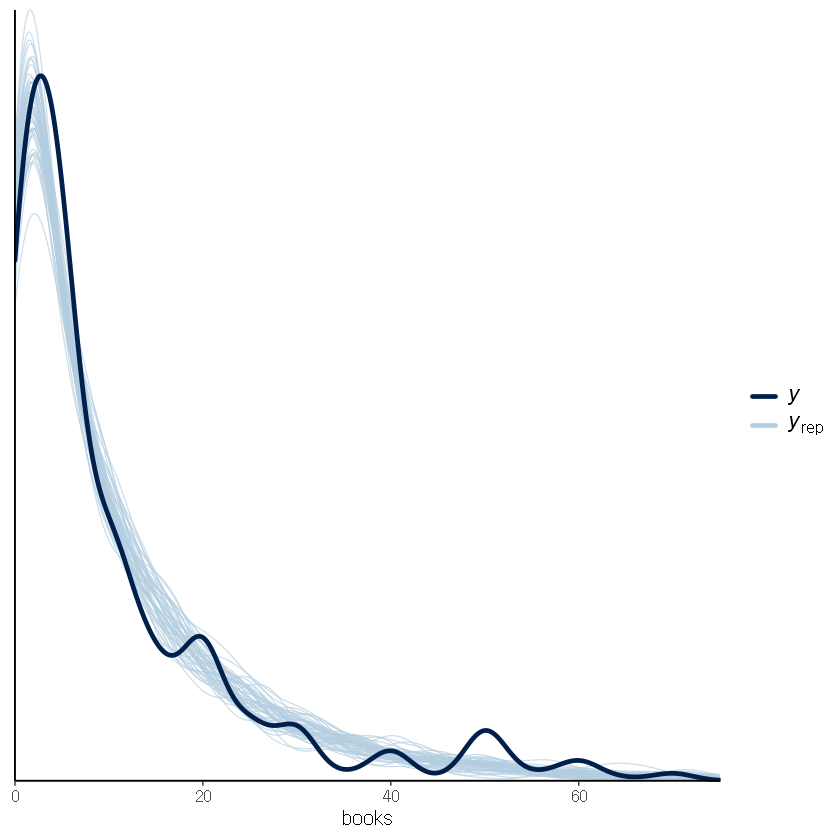

In [48]:
pp_check(books_negbin_sim) + 
  xlim(0, 75) + 
  xlab("books")

<br>

#### 매개변수별 사후분포 통계량


In [47]:
tidy(books_negbin_sim, conf.int = TRUE, conf.level = 0.80)

term,estimate,std.error,conf.low,conf.high
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),2.2341157443,0.131491877,2.067618127,2.40669867
age,0.0003645429,0.002393791,-0.002697845,0.00339496
wise_unwiseWise but Unhappy,0.2664426111,0.079811179,0.162238858,0.36838326
